##Predicting survival on the Titanic using logistic regression

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
sns.set(style="whitegrid", color_codes=True)

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 500

In [4]:
df = pd.read_csv('/Users/shannon/Documents/CSC570/data/train.csv')

In [5]:
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


###Data transformation
* Drop PassengerId and Name
* Get dummies for Sex and Pclass
* Calculate mean by Sex and Parch to fill in nulls for Age
* Calculate ticket length
* Get first letter of ticket
* Drop Ticket, Cabin, and Embarked

In [7]:
X = pd.DataFrame(df)

In [8]:
#Drop passengerid and name
X = X.drop(['PassengerId', 'Name'], axis=1)

In [9]:
#Get dummies for sex
#Female = 1, Male = 0
X.Sex = pd.get_dummies(X.Sex)['female']

In [10]:
X['Sex'][(X.Sex == 1)] = 100

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [11]:
X['Sex'][(X.Sex == 0)] = 10

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [12]:
X.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,41.717172,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,43.019106,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,10.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,10.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,10.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,100.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,100.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,10,22,1,0,A/5 21171,7.2500,NaN,S
1,1,1,100,38,1,0,PC 17599,71.2833,C85,C
2,1,3,100,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,100,35,1,0,113803,53.1000,C123,S
4,0,3,10,35,0,0,373450,8.0500,NaN,S


In [14]:
X.Age.mean()

29.69911764705882

In [15]:
#Creating values for null ages
female_no_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 100) & (df.Parch == 0)].mean()
male_no_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 10) & (df.Parch == 0)].mean()
female_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 100) & (df.Parch > 0) ].mean()
male_parch = X.Age[(X.Age.isnull() == False) & (X.Sex == 10) & (df.Parch > 0) ].mean()

In [16]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 100) & (X.Parch == 0)] = female_no_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 10) & (X.Parch == 0)] = male_no_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [18]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 100) & (X.Parch > 0)] = female_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [19]:
X['Age'][(X.Age.isnull() == True) & (X.Sex == 10) & (X.Parch > 0)] = male_parch

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [20]:
X[(X.Age.isnull() == True)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [21]:
X.Age.mean()

29.99899733306021

In [22]:
X['AgeClass'] = (X.Age * X.Pclass)

In [23]:
X['SexFare'] = (X.Sex * X.Fare)

In [24]:
X['AgeSex'] = (X.Age * X.Sex)

In [25]:
X['SexClass'] = (X.Sex * X.Pclass)

In [26]:
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,SexFare,AgeSex,SexClass
0,0,3,10,22,1,0,A/5 21171,7.2500,NaN,S,66,72.50,220,30
1,1,1,100,38,1,0,PC 17599,71.2833,C85,C,38,7128.33,3800,100
2,1,3,100,26,0,0,STON/O2. 3101282,7.9250,NaN,S,78,792.50,2600,300
3,1,1,100,35,1,0,113803,53.1000,C123,S,35,5310.00,3500,100
4,0,3,10,35,0,0,373450,8.0500,NaN,S,105,80.50,350,30


In [27]:
#Drop Pclass
X = X.drop(['Pclass'], axis=1)

In [28]:
X[X.Fare.isnull() == True]

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,SexFare,AgeSex,SexClass


In [29]:
#Create column for ticket length
X['ticket_length'] = [len(df.Ticket.iloc[x]) for x in range(len(df.Ticket))]

In [30]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeClass,SexFare,AgeSex,SexClass,ticket_length
0,0,10,22,1,0,A/5 21171,7.2500,NaN,S,66,72.50,220,30,9
1,1,100,38,1,0,PC 17599,71.2833,C85,C,38,7128.33,3800,100,8
2,1,100,26,0,0,STON/O2. 3101282,7.9250,NaN,S,78,792.50,2600,300,16
3,1,100,35,1,0,113803,53.1000,C123,S,35,5310.00,3500,100,6
4,0,10,35,0,0,373450,8.0500,NaN,S,105,80.50,350,30,6


In [31]:
#Create column for first letter of ticket
X['ticket_first'] = X['Ticket'].str[:1]

In [32]:
#Get dummies for first letter of ticket
X = X.join(pd.get_dummies(X.ticket_first, prefix='ticket_first'))

In [33]:
#Drop ticket
X = X.drop(['Ticket', 'ticket_first_S', 'ticket_first'], axis=1)

In [34]:
#Drop cabin
X = X.drop('Cabin', axis=1)

In [35]:
X.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,AgeClass,SexFare,AgeSex,SexClass,ticket_length,ticket_first_1,ticket_first_2,ticket_first_3,ticket_first_4,ticket_first_5,ticket_first_6,ticket_first_7,ticket_first_8,ticket_first_9,ticket_first_A,ticket_first_C,ticket_first_F,ticket_first_L,ticket_first_P,ticket_first_W
0,0,10,22,1,0,7.2500,S,66,72.50,220,30,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,1,100,38,1,0,71.2833,C,38,7128.33,3800,100,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,100,26,0,0,7.9250,S,78,792.50,2600,300,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,100,35,1,0,53.1000,S,35,5310.00,3500,100,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,10,35,0,0,8.0500,S,105,80.50,350,30,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
X['ParchSibSp'] = (X.SibSp * X.Parch)**2

In [37]:
X = X.drop(['Embarked', 'SibSp', 'Parch'], axis=1)

In [38]:
X.head()

,Survived,Sex,Age,Fare,AgeClass,SexFare,AgeSex,SexClass,ticket_length,ticket_first_1,ticket_first_2,ticket_first_3,ticket_first_4,ticket_first_5,ticket_first_6,ticket_first_7,ticket_first_8,ticket_first_9,ticket_first_A,ticket_first_C,ticket_first_F,ticket_first_L,ticket_first_P,ticket_first_W,ParchSibSp
0,0,10,22,7.2500,66,72.50,220,30,9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,100,38,71.2833,38,7128.33,3800,100,8,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1,100,26,7.9250,78,792.50,2600,300,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,100,35,53.1000,35,5310.00,3500,100,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,10,35,8.0500,105,80.50,350,30,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
X.describe()

,Survived,Sex,Age,Fare,AgeClass,SexFare,AgeSex,SexClass,ticket_length,ticket_first_1,ticket_first_2,ticket_first_3,ticket_first_4,ticket_first_5,ticket_first_6,ticket_first_7,ticket_first_8,ticket_first_9,ticket_first_A,ticket_first_C,ticket_first_F,ticket_first_L,ticket_first_P,ticket_first_W,ParchSibSp
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,41.717172,29.998997,32.204208,65.682451,1732.816100,1192.311885,91.571268,6.750842,0.163861,0.205387,0.337823,0.011223,0.003367,0.006734,0.010101,0.002245,0.001122,0.032548,0.052750,0.007856,0.004489,0.072952,0.014590,4.235690
std,0.486592,43.019106,13.086019,49.693429,33.534492,3995.818854,1424.826540,105.129135,2.745515,0.370357,0.404211,0.473233,0.105403,0.057961,0.081830,0.100051,0.047351,0.033501,0.177549,0.223659,0.088337,0.066890,0.260203,0.119973,24.826329
min,0.000000,10.000000,0.420000,0.000000,0.920000,0.000000,4.200000,10.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.000000,22.000000,7.910400,40.000000,80.500000,280.000000,20.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,10.000000,30.767974,14.454200,63.000000,291.250000,360.000000,30.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,100.000000,35.000000,31.000000,92.303922,1353.166500,2200.000000,100.000000,7.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,100.000000,80.000000,512.329200,222.000000,51232.920000,6300.000000,300.000000,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,256.000000


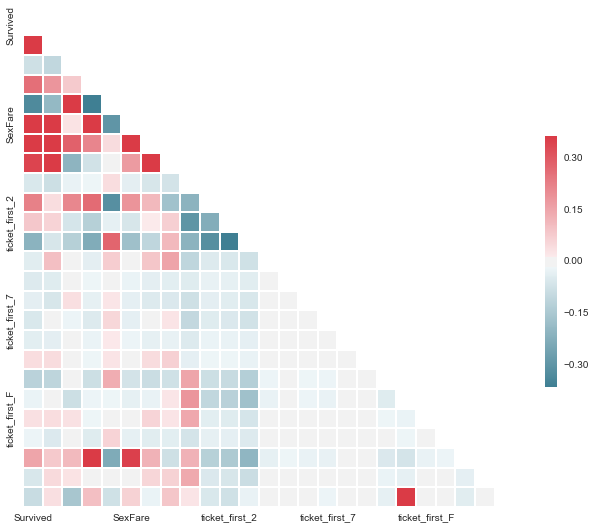

In [40]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [41]:
corr.sort(['Survived']).Survived

AgeClass         -0.331231
ticket_first_3   -0.212428
ticket_first_A   -0.118757
ParchSibSp       -0.090835
Age              -0.079495
ticket_first_W   -0.057546
ticket_first_7   -0.056649
ticket_length    -0.055331
ticket_first_5   -0.045876
ticket_first_4   -0.040274
ticket_first_8   -0.037436
ticket_first_6   -0.036769
ticket_first_C   -0.021066
ticket_first_L   -0.018481
ticket_first_F    0.034325
ticket_first_9    0.042470
ticket_first_2    0.084305
ticket_first_P    0.151310
ticket_first_1    0.224202
Fare              0.257307
SexClass          0.342265
SexFare           0.382581
AgeSex            0.485568
Sex               0.543351
Survived          1.000000
Name: Survived, dtype: float64

In [42]:
#Setting dependent variable to y and dropping from X
y = X.Survived
X = X.drop('Survived', axis=1)

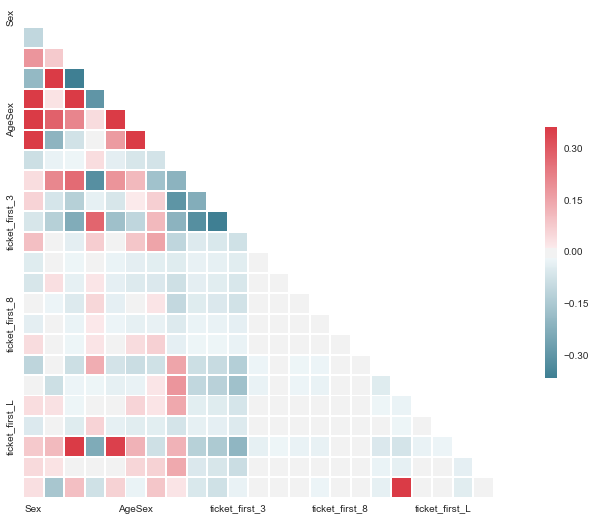

In [43]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

###Dropping more columns based on other feature importance

In [44]:
X = X.drop(['ticket_first_9','ticket_first_8', 'ticket_first_F', 'ticket_first_5', 'ticket_first_4', 'Age', 'Fare', 'Sex'], axis=1)

###Random Forest

In [45]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.87823954239


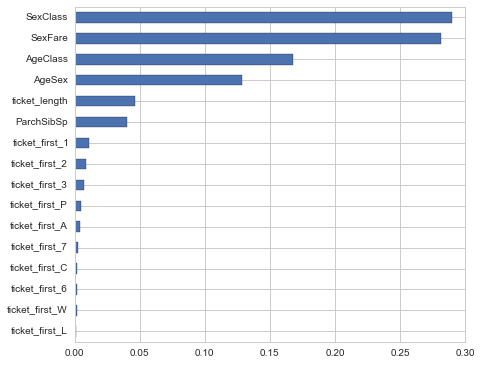

In [46]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort()
feature_importances.plot(kind="barh", figsize=(7,6));

####n_estimators

30 trees
C-stat:  0.869393048499

50 trees
C-stat:  0.870966882902

100 trees
C-stat:  0.87823954239

200 trees
C-stat:  0.877358088603

500 trees
C-stat:  0.87913697419

1000 trees
C-stat:  0.87983201781

2000 trees
C-stat:  0.879323384356

5000 trees
C-stat:  0.878583069696



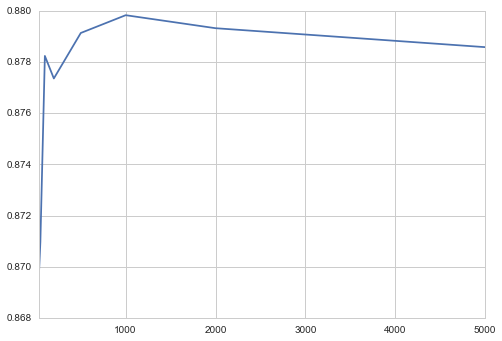

In [47]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000, 5000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print trees, "trees"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, n_estimator_options).plot();

####max_features

auto option
C-stat:  0.87983201781

None option
C-stat:  0.87983201781

sqrt option
C-stat:  0.881219442048

log2 option
C-stat:  0.881219442048

0.9 option
C-stat:  0.879560391568

0.2 option
C-stat:  0.881080965924



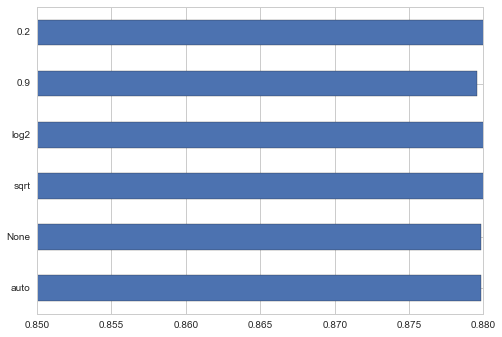

In [48]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print max_features, "option"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

####min_samples_leaf¶


1 min samples
C-stat:  0.881219442048

2 min samples
C-stat:  0.890124521991

3 min samples
C-stat:  0.889533335464

4 min samples
C-stat:  0.888276398343

5 min samples
C-stat:  0.885613395967

6 min samples
C-stat:  0.884958297383

7 min samples
C-stat:  0.883285931891

8 min samples
C-stat:  0.880441845354

9 min samples
C-stat:  0.879392622418

10 min samples
C-stat:  0.877091788366



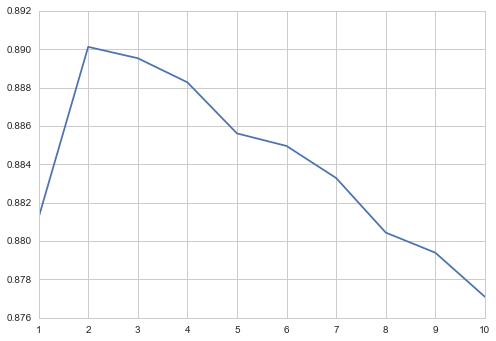

In [49]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features='sqrt', 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print min_samples, "min samples"
    roc = roc_auc_score(y, model.oob_prediction_)
    print "C-stat: ", roc
    results.append(roc)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

In [50]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features='sqrt', 
                              min_samples_leaf=2)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print "C-stat: ", roc

C-stat:  0.890124521991
